In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from matplotlib.patches import Rectangle
from matplotlib import cm
from scipy.stats import qmc
import math

2024-04-06 20:09:52.303628: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-06 20:09:52.351940: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-06 20:09:53.002461: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [2]:
# tf.random.set_seed(42)
# np.random.seed(42)

In [3]:
tf.keras.backend.set_floatx("float64")

In [4]:
class Puasson2DPINN():
    def __init__(self, input_shape=1, out_shape=1, layers=[10, 10, 10], activation='tanh', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-04)):
        super(Puasson2DPINN, self).__init__()
        self.optimizer = optimizer
        self.model = self.build(input_shape, out_shape, layers, activation)

    def build(self, input_shape, output_shape, layers, activation):
        input_layer = tf.keras.layers.Input(shape=(input_shape,))
        kernel_initializer=tf.keras.initializers.GlorotNormal(seed=177013)

        hidden = [tf.keras.layers.Dense(layers[0], activation=activation)(input_layer)]
        for i in range(1, len(layers)):
            new_layer = tf.keras.layers.Dense(
                    layers[i],
                    activation=activation,
                    activity_regularizer=None
                )(hidden[-1])
            hidden.append(new_layer)

        output_layer = tf.keras.layers.Dense(output_shape, activation=None)(hidden[-1])

        name = f"DNN-{len(layers)}"
        model = tf.keras.Model(input_layer, output_layer, name=name)
        model.summary()
    
        return model


    def forward(self, x1_x2):
        x1_x2 = tf.convert_to_tensor(x1_x2, dtype=tf.float64)
        
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch(x1_x2)
            with tf.GradientTape() as tape:
                tape.watch(x1_x2)
                u = self.model(x1_x2)
            grads = tape.gradient(u, x1_x2)
            u_x1, u_x2 = grads[:, 0], grads[:, 1]
        grads2 = tape2.gradient(u_x1, x1_x2)
        u_x1_x1 = grads2[:, 0]

        grads3 = tape2.gradient(u_x2, x1_x2)
        u_x2_x2 = grads3[:, 1]

        del tape2

        return u, u_x1, u_x2, u_x1_x1, u_x2_x2

    @tf.function
    def dirichlet_condition(self, x_d, y_d, t_d):
        x_t = tf.concat([x_d, y_d], axis=1)
        u = self.model(x_t)
        return tf.reduce_mean(tf.square(u - t_d))

    @tf.function
    def neuman_condition(self, x1_x2_bc_right):
        _, u_x1, _,  _, _ = self.forward(x1_x2_bc_right)
        return tf.reduce_mean(tf.square(u_x1)) # -∂u/∂x1 + ∂u/∂x1

    @tf.function
    def loss_fn(self, x_c, y_c, x_d, y_d, t_d):
        x_t = tf.concat([x_c, y_c], axis=1)
        u0 = self.model(x_t)
        u_x = tf.gradients(u0, x_c)[0]
        u_y = tf.gradients(u0, y_c)[0]
        u_xx = tf.gradients(u_x, x_c)[0]
        u_yy = tf.gradients(u_y, y_c)[0]
        puasson_eq = u_y - u_xx#self.f(x1_x2_train)
        bc_dirichlet = self.dirichlet_condition(x_d, y_d, t_d)
        #bc_neuman = self.neuman_condition(x_d, y_d, t_d)

        return tf.reduce_mean(tf.square(puasson_eq)) + 1 * (bc_dirichlet)
    
    def train(self, loss_threshold, x_c, y_c, x_d, y_d, t_d):
        loss_array = []
        start_time = time.time()

        loss = tf.constant(float('inf'))
        epoch = 0
        try:
            while loss.numpy() > loss_threshold:
                with tf.GradientTape() as tape:
                    loss = self.loss_fn(x_c, y_c, x_d, y_d, t_d)
                grads = tape.gradient(loss, self.model.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

                loss_array.append(loss)
                if epoch % 100 == 0:
                    print(f'Epoch {epoch}, Loss: {loss.numpy()}')
                epoch += 1
        except KeyboardInterrupt:
            print("Training stopped manually")

        print("Training took %s seconds" % (time.time() - start_time))
        print(f"Last epoch: {epoch}, loss: {loss.numpy()}")

        plt.plot(loss_array)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid()
        plt.title('Mean loss')
        plt.savefig("2d_poisson_equation_training.png")
        plt.show(block=False)

    def f(self, x1_x2):
        x1 = np.array([x[0] for x in x1_x2])
        x2 = np.array([x[1] for x in x1_x2])
        return -np.pi * np.sin(np.pi * x1) * np.sin(np.pi * x2)

2024-04-06 19:38:41.594898: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 19:38:41.651436: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 19:38:41.651494: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 19:38:41.657418: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 19:38:41.657525: I tensorflow/compile

Model: "DNN-9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 20)                420   

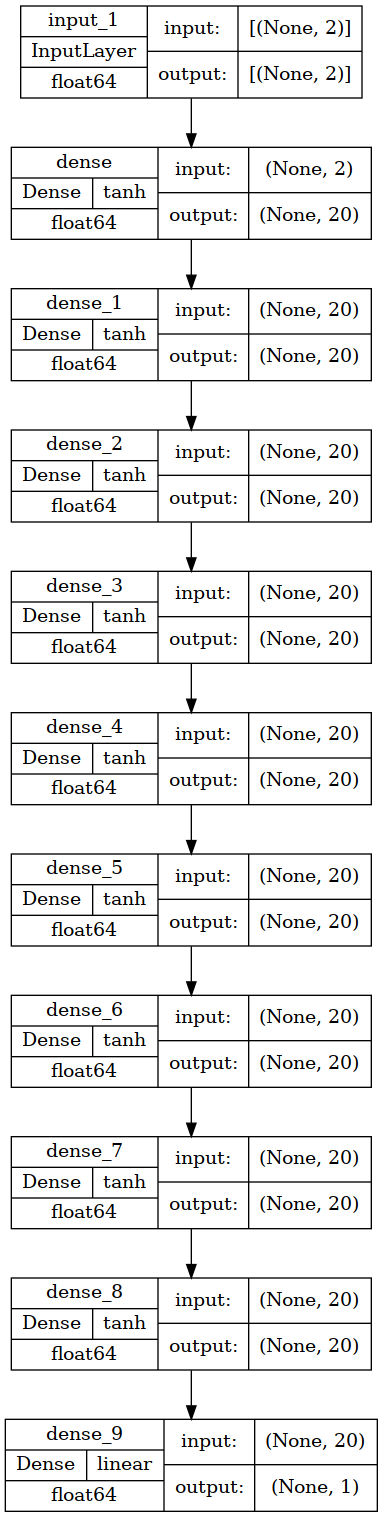

In [5]:
N_of_train_points_2D = 141
N_of_test_points_2D = 1000
L_x = -0.0
R_x = 1.0
L_t = 0.0
R_t = 1.0
Dirichlet_up_2D = 0.0
Dirichlet_down_2D = 0.0
loss_threshold_2D = 1e-3
Layers_2D = [20, 20, 20, 20, 20, 20, 20, 20, 20]
Learning_rate_2D = 5e-4
Optimizer_2D = tf.keras.optimizers.Adam(learning_rate=Learning_rate_2D)


model_2D = Puasson2DPINN(2, 1, Layers_2D, 'tanh', Optimizer_2D)
tf.keras.utils.plot_model(model_2D.model, to_file='model_plot.png', show_shapes=True, 
                          show_layer_names=True, show_dtype=True, 
                          show_layer_activations=True)

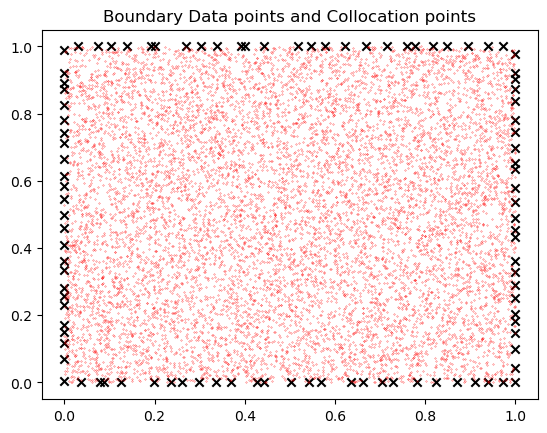

In [6]:
### data generation
n_bc = 4
n_data_per_bc = 25
#
engine = qmc.LatinHypercube(d=1)
data = np.zeros([n_bc, n_data_per_bc, 3])

L_x = 0
R_x = 1
L_t = 0
R_t = 1

for i, j in zip(range(n_bc), [L_x, R_x, L_t, R_t]):
    if i < 2:
        points = L_t + engine.random(n=n_data_per_bc)[:, 0] * (R_t - L_t)
        data[i, :, 0] = j
        data[i, :, 1] = points
    else:
        points = L_x + engine.random(n=n_data_per_bc)[:, 0] * (R_x - L_x)
        data[i, :, 0] = points
        data[i, :, 1] = j

# BC Values
# normalized in [0, 1]
data[0, :, 2] = 0. # x = -1
data[1, :, 2] = 0. # x = -1
values = np.sin(math.pi*data[2, :, 0]) - np.sin(2*math.pi*data[2, :, 0]) + np.sin(3*math.pi*data[2, :, 0])
data[2, :, 2] = values # y/t = -1

data = data.reshape(n_data_per_bc * n_bc, 3)
#
x_d, y_d, t_d = map(lambda x: np.expand_dims(x, axis=1), 
                    [data[:, 0], data[:, 1], data[:, 2]])

#

Nc = 10000
engine = qmc.LatinHypercube(d=2)
colloc = engine.random(n=Nc)
colloc = np.column_stack((L_x + colloc[:,0] * (R_x - L_x), L_t + colloc[:,1] * (R_t - L_t)))

x_c, y_c = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1]])

#

plt.title("Boundary Data points and Collocation points")
plt.scatter(data[:, 0], data[:, 1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=.2, marker=".", c="r", label="CP")
plt.show()

#

x_c, y_c, x_d, y_d, t_d =map(lambda x: tf.convert_to_tensor(x,dtype=tf.float64),
                             [x_c, y_c, x_d, y_d, t_d])

2024-04-06 19:38:43.151983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_21' with dtype int32
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_21}}]]
2024-04-06 19:38:43.885926: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0xa1c0de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-06 19:38:43.886291: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti Laptop GPU, Compute Capability 8.6
2024-04-06 19:38:43.892779: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-06 19:38:43.914790: I 

Epoch 0, Loss: 0.7276293709014932
Epoch 100, Loss: 0.24977813594805626
Epoch 200, Loss: 0.23449059769130837
Epoch 300, Loss: 0.20147573988675974
Epoch 400, Loss: 0.17424518786912777
Epoch 500, Loss: 0.1611349457985077
Epoch 600, Loss: 0.15279444872536072
Epoch 700, Loss: 0.1443912582008726
Epoch 800, Loss: 0.14945514884035865
Epoch 900, Loss: 0.1366682792162005
Epoch 1000, Loss: 0.14284307001903884
Epoch 1100, Loss: 0.13247270391715593
Epoch 1200, Loss: 0.13074968840260348
Epoch 1300, Loss: 0.12868767665338388
Epoch 1400, Loss: 0.1345527217387634
Epoch 1500, Loss: 0.12596730549086646
Epoch 1600, Loss: 0.1240716632350033
Epoch 1700, Loss: 0.12278929830093459
Epoch 1800, Loss: 0.12177047275816748
Epoch 1900, Loss: 0.1202800889621246
Epoch 2000, Loss: 0.11886810608559695
Epoch 2100, Loss: 0.12349367130758433
Epoch 2200, Loss: 0.12124435430852869
Epoch 2300, Loss: 0.11615423020437404
Epoch 2400, Loss: 0.11505589842613219
Epoch 2500, Loss: 0.1542470735096721
Epoch 2600, Loss: 0.122754236674

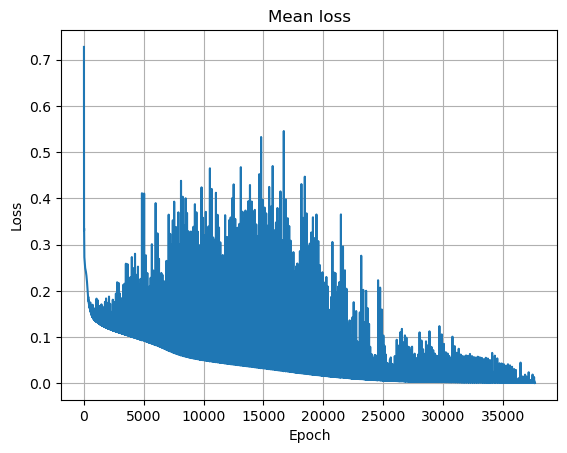

In [7]:
model_2D.train(loss_threshold_2D, x_c, y_c, x_d, y_d, t_d)

In [8]:
def save_and_load_model_2D(model, layers, fileName):
    # Save weights to file
    model.save_weights(f'{fileName}.h5')

    # Instantiate a new model with the same layers and wave speed
    new_model = Puasson2DPINN(layers)

    # Create some dummy input
    dummy_x = np.linspace(0, 1, 10)
    dummy_t = np.linspace(0, 1, 10)
    dummy_xt = np.array([[x1, x2] for x1 in dummy_x for x2 in dummy_t], dtype=np.float64)

    # Call the model on the dummy input to create variables
    _ = new_model(dummy_xt)

    # Load the weights from the saved file
    loaded_model = new_model.load_weights(f'{fileName}.h5')
    return loaded_model
#save_and_load_model_2D(model, layers)

In [9]:
def calculate_max_relative_error(u_pred, u_exact):
    return 100 * np.linalg.norm(u_exact - u_pred, np.inf) / np.linalg.norm(u_exact, np.inf)

In [10]:
# Visualize the solution
x1_test = np.linspace(L_x, R_x, N_of_test_points_2D)[:, np.newaxis]
x2_test = np.linspace(L_t, R_t, N_of_test_points_2D)[:, np.newaxis]
x1_mesh, x2_mesh = np.meshgrid(x1_test, x2_test)
x1x2_test = np.hstack((x1_mesh.flatten()[:, np.newaxis], x2_mesh.flatten()[:, np.newaxis]))

u_pinn = model_2D.model(x1x2_test).numpy().reshape(x1_test.shape[0], x2_test.shape[0])

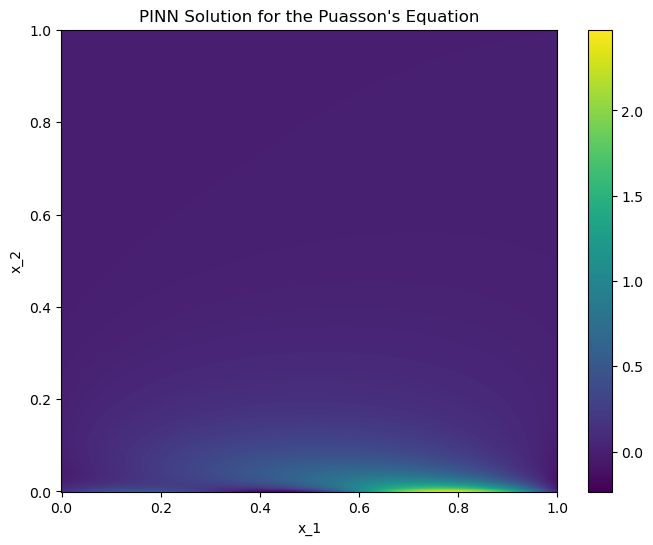

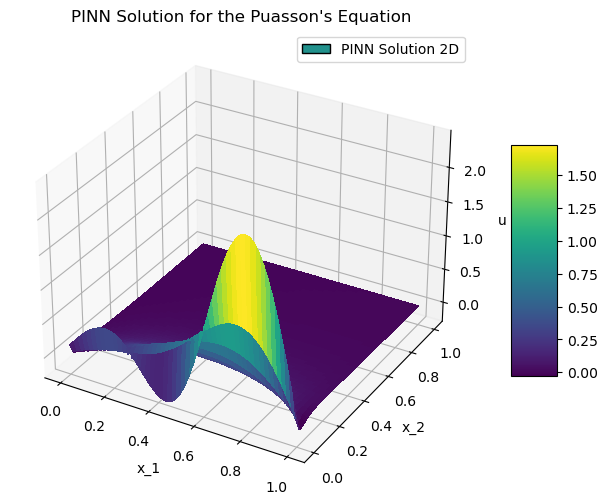

In [11]:
plt.figure(figsize=(8, 6))
plt.pcolor(x1_mesh, x2_mesh, u_pinn, cmap='viridis')
plt.colorbar()
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.title('PINN Solution for the Puasson\'s Equation')
plt.savefig("2d_poisson_equation_exact_solution_heatmap.png")
plt.show(block=False)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
# line, = ax.plot(np.ones_like(x_test_1D) * 0.5, x_test_1D, u_pred_1D, label='PINN Solution 1D', zorder=2)
# line2, = ax.plot(np.ones_like(x_test_1D) * 0.5, x_test_1D, U_exact_1D, label='Exact Solution 1D', zorder=1)
surf = ax.plot_surface(x1_mesh, x2_mesh, u_pinn, cmap='viridis', linewidth=0, antialiased=False, label='PINN Solution 2D', zorder=0)
#ax.plot(np.ones_like(x_test_1D) * 0.5, x_test_1D, U_exact_1D, label='Exact Solution 1D')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_zlabel('u')
ax.set_title('PINN Solution for the Puasson\'s Equation')
color_for_legend = cm.viridis(0.5)  # Get the color from the colormap
proxy = Rectangle((0, 0), 1, 1, fc=color_for_legend, edgecolor="k")
ax.legend([proxy], ['PINN Solution 2D'])
#ax.legend([line, line2, proxy], ['PINN Solution 1D', 'Exact Solution 1D', 'PINN Solution 2D'])
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig("2d_poisson_equation_approx_solution.png")
plt.show()

In [12]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Define domain and mesh for 1D
N = N_of_test_points_2D-1
mesh = IntervalMesh(N, L_x, R_x)

# Define function space for 1D
V = FunctionSpace(mesh, 'P', 1)

# Boundary conditions setup
def boundary_left(x, on_boundary):
    return on_boundary and near(x[0], L_x)

def boundary_right(x, on_boundary):
    return on_boundary and near(x[0], R_x)

bc = [DirichletBC(V, Constant(0), boundary_left),
      DirichletBC(V, Constant(0), boundary_right)]

# Initial condition
u_0 = Expression('sin(pi*x[0]) - sin(2*pi*x[0]) + sin(3*pi*x[0])', degree=2)
u_n = interpolate(u_0, V)

# Variational problem setup
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0)
alpha = Constant(1.0)
dt = (R_t - L_t) / N  # Time step size

F = u*v*dx + dt*alpha*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)

# Prepare for storing solutions
times = np.arange(L_t, R_t + dt/2, dt)
u_fem = np.zeros((len(times), N_of_test_points_2D))

# Time-stepping
u = Function(V)
for n, t in enumerate(times):
    solve(a == L, u, bc)
    u_n.assign(u)
    u_fem[n, :] = u.compute_vertex_values(mesh)


bash: /home/user/miniconda3/envs/fenicsproject/lib/libtinfo.so.6: no version information available (required by bash)
bash: /home/user/miniconda3/envs/fenicsproject/lib/libtinfo.so.6: no version information available (required by bash)


Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

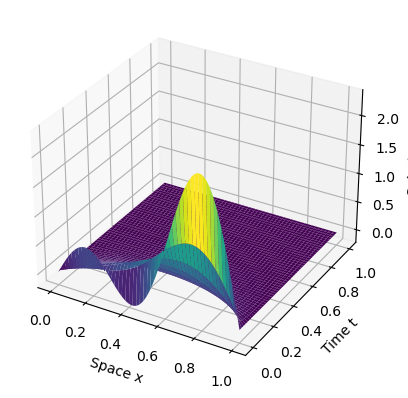

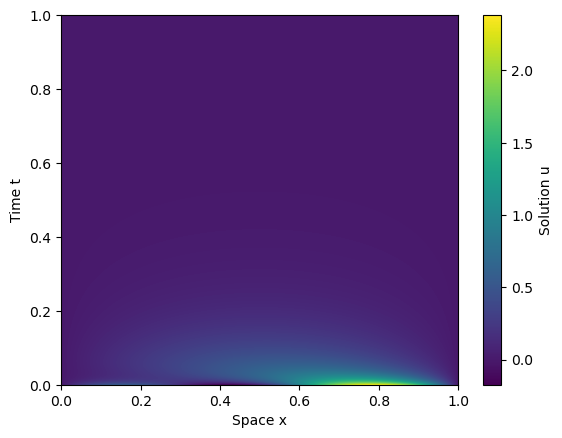

In [13]:
# 3D plotting
X, T = np.meshgrid(np.linspace(L_x, R_x, N+1), times)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, u_fem, cmap='viridis')

ax.set_xlabel('Space x')
ax.set_ylabel('Time t')
ax.set_zlabel('Solution u')
plt.show()

# Plot the heatmap
solutions_np = np.array(u_fem)
fig, ax = plt.subplots()
c = ax.imshow(solutions_np, extent=[L_x, R_x, times[0], times[-1]], origin='lower', aspect='auto', cmap='viridis')
ax.set_xlabel('Space x')
ax.set_ylabel('Time t')

# Add a colorbar
cbar = fig.colorbar(c, ax=ax)
cbar.set_label('Solution u')

plt.show()

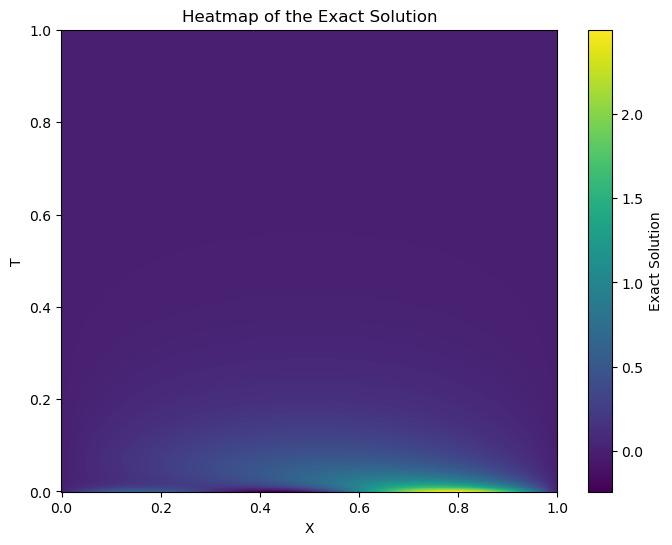

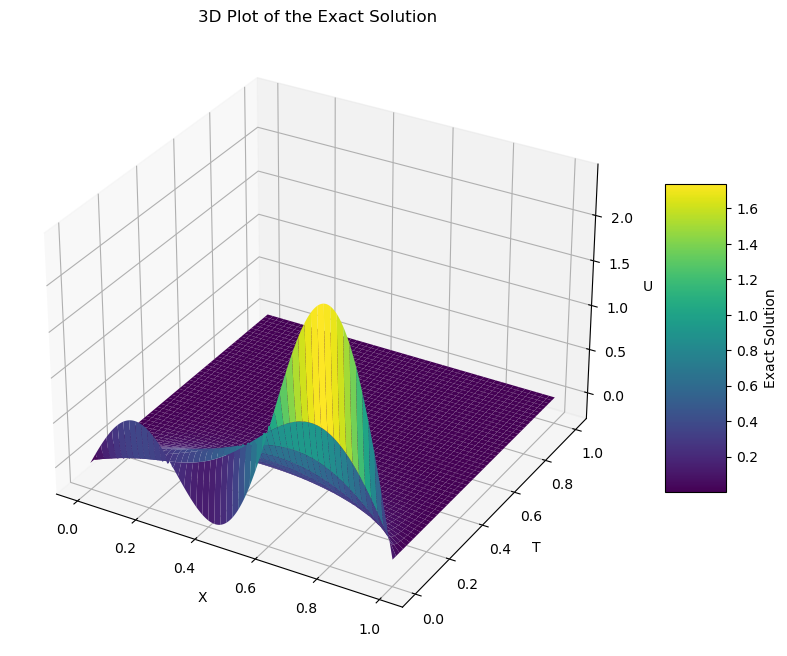

In [15]:
def exact_solution(x, t):
    term1 = np.exp(-np.power(np.pi, 2) * t) * np.sin(np.pi * x)
    term2 = -np.exp(-np.power(2 * np.pi, 2) * t) * np.sin(2 * np.pi * x)
    term3 = np.exp(-np.power(3 * np.pi, 2) * t) * np.sin(3 * np.pi * x)
    return term1 + term2 + term3


x = np.linspace(L_x, R_x, N_of_test_points_2D)
t = np.linspace(L_t, R_t, N_of_test_points_2D)
X, T = np.meshgrid(x, t)

u_exact = exact_solution(X, T)

plt.figure(figsize=(8, 6))
plt.pcolormesh(X, T, u_exact, cmap='viridis', shading='auto')
plt.colorbar(label='Exact Solution')
plt.xlabel('X')
plt.ylabel('T')
plt.title('Heatmap of the Exact Solution')
plt.show()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, T, u_exact, cmap='viridis', edgecolor='none')
fig.colorbar(surf, shrink=0.5, aspect=5, label='Exact Solution')

ax.set_xlabel('X')
ax.set_ylabel('T')
ax.set_zlabel('U')
ax.set_title('3D Plot of the Exact Solution')
plt.show()

In [16]:
print("Mean Squared Error (PINN and FEM):", np.mean((u_fem - u_pinn)**2))
relative_error = calculate_max_relative_error(u_fem, u_pinn)
print(f"Relative error (PINN and FEM): {relative_error:.2f}%")

Mean Squared Error (PINN and FEM): 0.00010886232121119184
Relative error (PINN and FEM): 6.38%


In [17]:
print("Mean Squared Error (PINN and Exact):", np.mean((u_exact - u_pinn)**2))
relative_error = calculate_max_relative_error(u_exact, u_pinn)
print(f"Relative error (PINN and Exact): {relative_error:.2f}%")

Mean Squared Error (PINN and Exact): 9.78306041303643e-05
Relative error (PINN and Exact): 4.34%


In [18]:
print("Mean Squared Error (FEM and Exact):", np.mean((u_fem - u_exact)**2))
relative_error = calculate_max_relative_error(u_fem, u_exact)
print(f"Relative error (FEM and Exact): {relative_error:.2f}%")

Mean Squared Error (FEM and Exact): 2.1324174961181513e-05
Relative error (FEM and Exact): 6.08%
